Introduction to Data Science <br> Winter 2018

# Homework 6
Due Saturday, 2/19 , 3:00am

Please complete this notebook by filling in the cells provided. Once you are finished, "Save and Checkpoint" the notebook, download the ipynb and html versions to your computer, and submit the html version. 

**Each question is worth 10 points** <br>
**Total points: 60**

In this homework you will use a permutation tests to analyze data from a clinical trial. 

A summary of the methods to Table is [here](http://data8.org/datascience/tables.html) <br>
A tutorial for the datascience module is [here](http://data8.org/datascience/tutorial.html) <br>
A cheatsheet for the datascience module is [here](https://github.com/wstuetzle/STAT180/blob/master/Computing/data8_sp17_midterm_ref_sheet.pdf)

In [1]:
from datascience import *
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

### Does Rogain promote hair growth ?

You will analyze the results of a randomized, double blind clinical trial to evaluate the effectiveness of Rogaine in promoting hair growth. There were 1431 subjects, of whom 714 were treated with Rogaine and 717 received a placebo. Here is a table summarizing the outcome of the experiment:

In [2]:
observed_counts = Table.read_table("rogaine_observed_counts.csv")
observed_counts

treatment,dense_growth,minimal_growth,moderate_growth,new_vellus,no_growth
Placebo,1,114,29,150,423
Rogaine,5,178,58,172,301


It does look like subjects who received Rogaine fared better than subjects who received a placebo. You want to find out whether there really is an association between treatment and outcome or whether the difference could just have been due to luck of the draw in the random assignment of subjects to Rogaine and Placebo. 

** Here is the basic idea: **

There were 1431 subjects, of whom 714 (let's call that half) were treated with Rogaine.

Consider the "no_growth" column. There were 724 subjects with outcome "no_growth". If there was no treatment effect you would expect them to be split 50/50 between "Placebo" and "Rogaine", just like the overall pool of subjects. So under the null hypotheses of no treatment effect you would expect the "no_growth" column to be (362, 362).

The same argument can be made for the other four columns.

** Question 1. ** Write Python code to compute the table of expected counts (under the hypotheses of no treatment effect). Call this table "expected_counts". Print the table.

** Note: ** If this takes you too long and you run out of patience, you can compute the table of expected counts "by hand".

In [3]:
n_placebo = make_array(observed_counts.drop('treatment').row(0)).sum()
n_treatment = make_array(observed_counts.drop('treatment').row(1)).sum()
n_total = n_placebo + n_treatment
print('There were', n_placebo, 'subjects assigned placebo and', n_treatment, 'subjects assigned Rogaine out of', 
      n_total, 'total subjects.')
expected_counts = Table()
for label in observed_counts.labels:
    if label == 'treatment':
        expected_counts = expected_counts.with_column(label, observed_counts.column(label))
    else:
        expected_counts = expected_counts.with_column(label, np.round(observed_counts.column(label).sum() * 
                                                                      make_array(n_placebo/n_total, n_treatment/n_total)))

expected_counts.show()

There were 717 subjects assigned placebo and 714 subjects assigned Rogaine out of 1431 total subjects.


treatment,dense_growth,minimal_growth,moderate_growth,new_vellus,no_growth
Placebo,3,146,44,161,363
Rogaine,3,146,43,161,361


Now we need a measure of distance between the observed and expected tables. A commonly used measure is the Chi-square distance, defined as 
\begin{equation}
Chi2 = \sum_{rows} \sum_{columns} \frac{(observed\_count - expected\_count)^2}{expected\_count}
\end{equation}

** Question 2. ** Write a Python function  Chi_square_distance(observed_counts, expected_counts)  that computes the Chi-square distance between a table of observed counts and a table of expected counts. Compute and print the distance.

In [4]:
def chi_square_distance(observed, expected):
    chi2 = 0
    for i in [0, 1]:
        obs_row = make_array(observed.drop('treatment').row(i))
        exp_row = make_array(expected.drop('treatment').row(i))
        chi2 = chi2 + (obs_row - exp_row)**2/exp_row
    return chi2.sum()
observed_chi_square = chi_square_distance(observed_counts, expected_counts)
observed_chi_square

48.433018561049892

Next you need to randomly permute the treatment labels, thereby destroying any association between treatment and outcome, and find out what values of the Chi-square distance you would obtain under the null hypotheses of "no association" (or equivalently "no treatment effect")

To do that you first need to make up the raw_data table that gave rise to the observed_counts. The raw_data table will have 1,431 rows (one for each subject), and two columns, "treatment" and "outcome". The treatment column has entries "Rogaine" and "Placebo". The outcome column has entries "no_growth", "new_vellus", ... , "dense_growth"

** Question 3. ** Write Python code to create a raw_data table that such that raw_data.pivot("outcome", "treatment") 
produces the observed counts.

** Hints: **

np.full(714, "Rogaine") produces an array of length 714 filled with the string "Rogaine" <br>
np.concatenate([array1, array2, array3]) glues any number of arrays together into a single array

In [28]:
placebo_row = observed_counts.drop('treatment').row(0)
treatment_row = observed_counts.drop('treatment').row(1)
placebo_outcomes = []
treatment_outcomes = []
labels = observed_counts.drop('treatment').labels
for i in np.arange(0, len(labels)):
    placebo_outcomes = placebo_outcomes + [labels[i]]*placebo_row.item(i)
    treatment_outcomes = treatment_outcomes + [labels[i]]*treatment_row.item(i)
       
raw_data = Table()
raw_data = raw_data.with_columns('treatment', np.concatenate([np.full(n_placebo, 'Placebo'), np.full(n_treatment, 'Rogaine')]), 
                                 'outcome', placebo_outcomes + treatment_outcomes)
raw_data.pivot("outcome", "treatment")

treatment,dense_growth,minimal_growth,moderate_growth,new_vellus,no_growth
Placebo,1,114,29,150,423
Rogaine,5,178,58,172,301


Now you are ready for the permutation test:

* generate 1,000 permuted_raw_data tables by randomly permuting the "treatment" column of raw_data
* for each permuted_raw_data table compute the table of counts - let's call it permuted_counts.
* for each permuted_counts table compute permuted_chi_square = Chi_square_distance(permuted_counts, expected_counts)

You end up with 1,000 values for permuted_chi_square. Put them in a table permuted_chi_square_table with one column named "permuted_chi_square".

** Question 4. ** Draw a histogram of the 1,000 values of permuted_chi_square

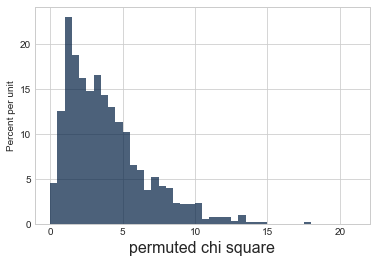

In [12]:
n_perms = 1000

permuted_chi_square = np.zeros(n_perms)
permuted_labels = raw_data.sample(k = n_perms, with_replacement = False).column('treatment')
for i in np.arange(n_perms):
    permuted_labels = raw_data.select('treatment').sample(k = n_total, with_replacement = False).column('treatment')
    permuted_data = raw_data.drop('treatment')
    permuted_data = permuted_data.with_column('treatment', permuted_labels)
    permuted_counts = permuted_data.pivot('outcome', 'treatment')
    permuted_chi_square[i] = chi_square_distance(expected = expected_counts, observed = permuted_counts)

permuted_chi_square_table = Table().with_column('permuted chi square', permuted_chi_square)
permuted_chi_square_table.hist('permuted chi square', bins = np.arange(0, permuted_chi_square.max(), 0.5))

** Question 5. ** Compute the p_value of the test  (See comment below)

In [18]:
p_value = (permuted_chi_square > observed_chi_square).sum()/n_perms
p_value

0.0

** Question 6. ** Here are two alternative explanation for the distance between observed and expected counts:

(a) Rogaine has no effect. The manufacturers of Rogaine were lucky: Rogaine just happened to be assigned to subjects whose hair would have improved no matter what.

(b) There is an association between treatment and outcome. Rogaine does promote hair growth.

Choose (a) or (b)

In [19]:
q6_answer = 'b'

** Comment on p-value ** 

It obviously can't be zero. It really is 1 / (nperm + 1)

** Reason: ** Suppose there was no treatment effect. Then we would have observed the value chi-square for nperm + 1 random permutations of the treatment labels: the "original" one from the random assignment of treatments to subjects, and nperm "reference" ones for the permutation test. The probability that the chi_square value of the original one is among the k largest of the (nperm + 1) permutations is k / (nperm + 1). In our case k = 1, so the p-value is 1 / 1001.